##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
# !pip install -U -q tensorflow
from tensorflow.python.keras.metrics import mse

2025-04-16 15:30:47.246126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744799447.261785    3363 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744799447.266344    3363 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744799447.278207    3363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744799447.278226    3363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744799447.278228    3363 computation_placer.cc:177] computation placer alr

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from sklearn.model_selection import KFold

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# !pip install "neptune[tensorflow-keras]"

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [6]:
AUDIO_LENGTH = 41600

In [7]:
# DATASET_PATH = 'data/mini_speech_commands'

# data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [8]:
# import zipfile

# def unzip_file(zip_path, extract_to_folder):
#     try:
#         # Открываем zip-файл для чтения
#         with zipfile.ZipFile(zip_path, 'r') as zipf:
#             # Извлекаем все файлы в указанную папку
#             zipf.extractall(extract_to_folder)
#             print(f"Архив успешно извлечен в папку: {extract_to_folder}")
#     except Exception as e:
#         print(f"Ошибка при извлечении: {e}")

# # Пример использования
# zip_path = "/content/ML.zip"  # Укажите путь к вашему zip файлу
# extract_to_folder = "/content/ML"  # Укажите путь, куда нужно извлечь файлы

# # Создаем папку, если она не существует
# os.makedirs(extract_to_folder, exist_ok=True)

# unzip_file(zip_path, extract_to_folder)


In [9]:
data_dir = "output/ML"

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [10]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['Catch' 'Gun' 'Index' 'Like' 'Relax' 'Rock']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [11]:
train_ds, test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=None,
    validation_split=0.1,
    seed=0,
    output_sequence_length=AUDIO_LENGTH,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 6815 files belonging to 6 classes.
Using 6134 files for training.
Using 681 files for validation.


I0000 00:00:1744799454.128579    3363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



label names: ['Catch' 'Gun' 'Index' 'Like' 'Relax' 'Rock']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [12]:
train_ds.element_spec

(TensorSpec(shape=(41600, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [13]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [14]:
# for example_audio, example_labels in train_ds.take(1):
#   print(example_audio.shape)
#   print(example_labels.shape)

In [15]:
example_audio = []
example_labels = []
for (audio, label) in list(train_ds):
  example_audio.append(audio)
  example_labels.append(label)

2025-04-16 15:30:59.535017: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's plot a few audio waveforms:

In [16]:
label_names[[1,1,3,0]]

array(['Gun', 'Gun', 'Like', 'Catch'], dtype='<U5')

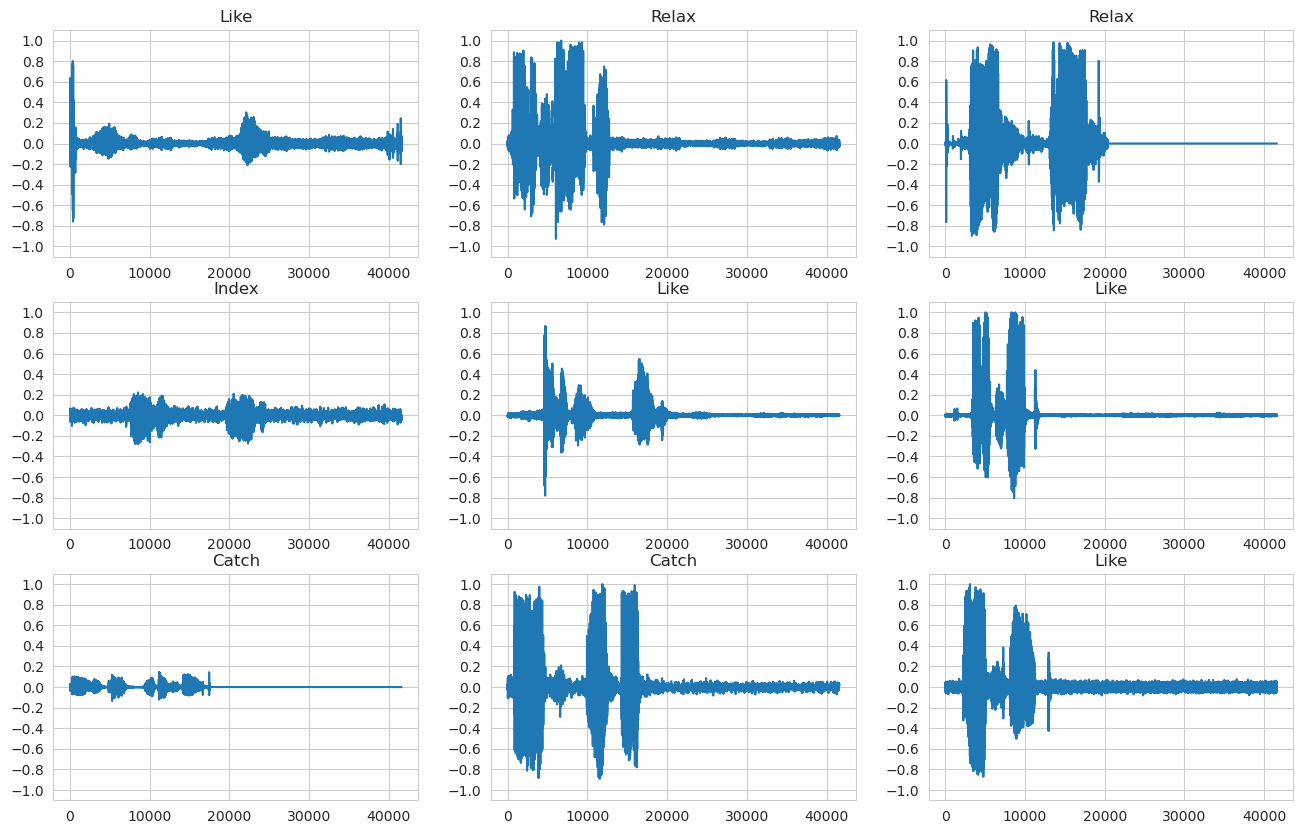

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [18]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    spectrogram = tf.image.resize(spectrogram, [128, 64])
    nonzero_elements = tf.boolean_mask(spectrogram, spectrogram != 0)
    nonzero_median = tf.sort(nonzero_elements)[tf.shape(nonzero_elements)[0] // 4]
    spectrogram = tf.where(spectrogram == 0, nonzero_median, spectrogram)
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [19]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: Like
Waveform shape: (41600,)
Spectrogram shape: (128, 64, 1)
Audio playback


Label: Relax
Waveform shape: (41600,)
Spectrogram shape: (128, 64, 1)
Audio playback


Label: Relax
Waveform shape: (41600,)
Spectrogram shape: (128, 64, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

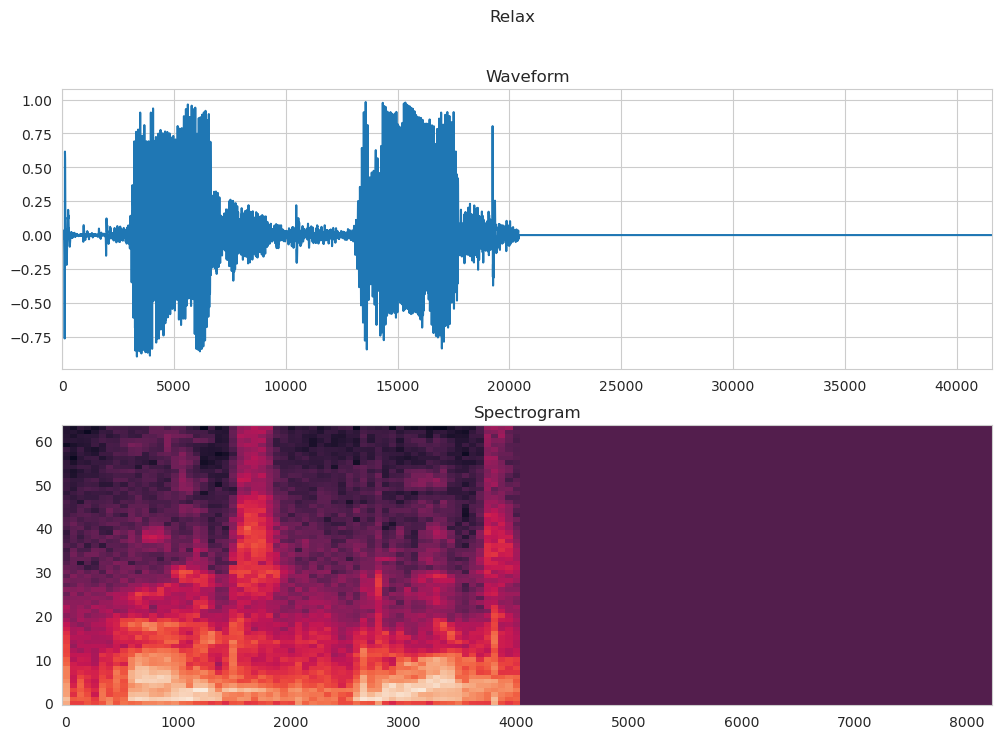

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, AUDIO_LENGTH])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [22]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_spectrogram_ds = make_spec_ds(train_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [24]:
example_spectrograms = []
example_spect_labels = []
for (spect, spect_label) in list(train_spectrogram_ds):
  example_spectrograms.append(spect)
  example_spect_labels.append(spect_label)

2025-04-16 15:31:09.602772: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


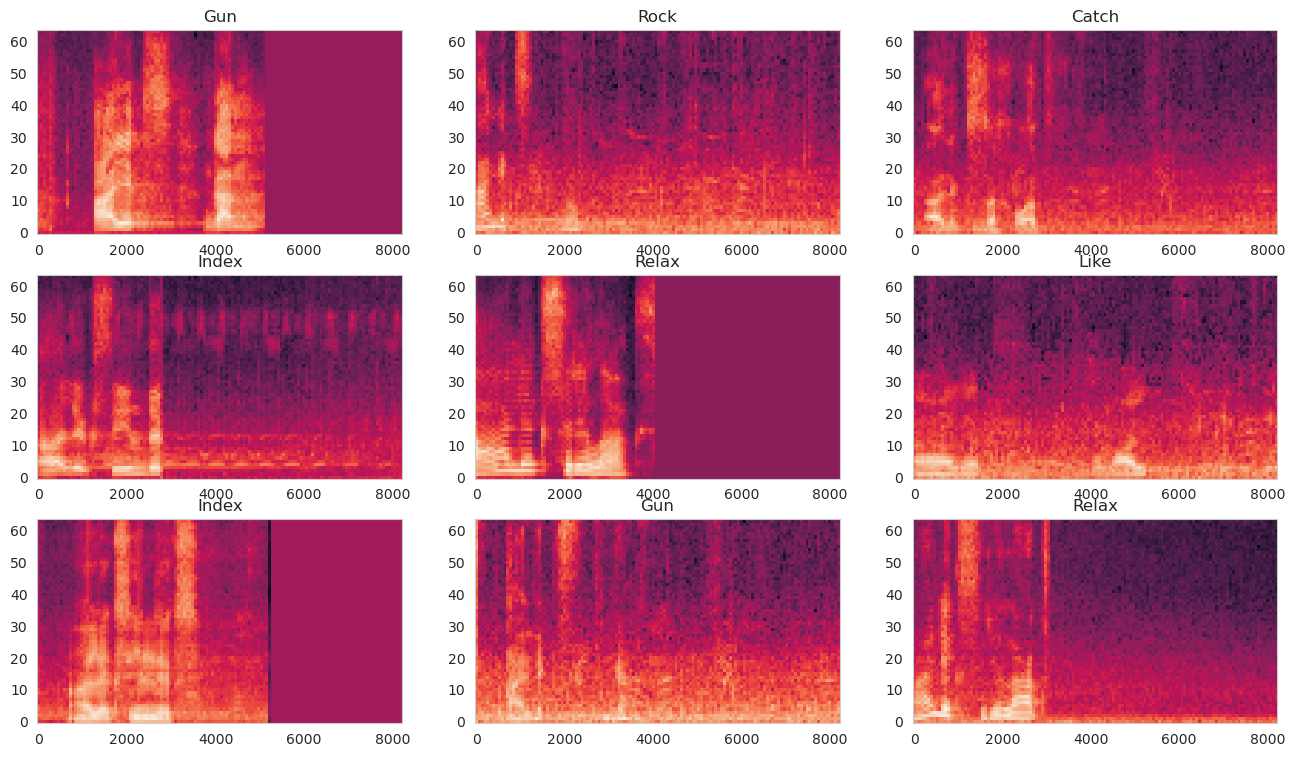

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [26]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)

In [27]:
input_shape = example_spectrograms[0].shape
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (128, 64, 1)


Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [28]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

LEARNING_RATE = 0.001


def build_model(input_shape, num_labels, class_loss_weight, recon_loss_weight):
    # Нормализация входных данных
    norm_layer = layers.Normalization()

    inputs = layers.Input(shape=input_shape)
    x = norm_layer(inputs)

    # Энкодер: последовательность свёрточных слоёв и пулинга
    x = layers.Conv2D(8, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(16, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(16, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(16, 3, activation='relu', padding="same")(x)
    x = layers.MaxPooling2D((1, 4))(x)
    x = layers.Flatten()(x)
    # Переход к полносвязной части

    encoded = layers.Dropout(0.25)(x)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dropout(0.25)(encoded)

    # Ветвь классификации
    class_output = layers.Dense(num_labels, name='classification_output')(encoded)

    # Ветвь декодера (восстановление спектрограммы)
    x2 = layers.Concatenate(axis=1)([x, class_output])
    x2 = layers.Dropout(0.25)(x2)
    x2 = layers.Dense(128, activation='relu')(x2)

    x2 = layers.Reshape((8, 1, 16))(x2)
    x2 = layers.Conv2DTranspose(16, kernel_size=2, strides=(1, 4),
                                activation='relu', padding='same')(x2)
    x2 = layers.Conv2DTranspose(16, kernel_size=2, strides=2,
                                activation='relu', padding='same')(x2)
    x2 = layers.Conv2DTranspose(16, kernel_size=2, strides=2,
                                activation='relu', padding='same')(x2)
    x2 = layers.Conv2DTranspose(16, kernel_size=2, strides=2,
                                activation='relu', padding='same')(x2)
    decoder_output = layers.Conv2DTranspose(input_shape[-1], kernel_size=2, strides=2,
                                activation='relu', padding='same', name='reconstruction_output')(x2)

    # Модель с двумя выходами: для классификации и для восстановления спектрограммы
    model = models.Model(inputs=inputs,
                         outputs=[class_output, decoder_output])

    # Задаём функции потерь для каждой из ветвей.
    # Для классификации используем SparseCategoricalCrossentropy (с from_logits=True, если выход не проходит softmax)
    # Для восстановления – MeanAbsolutePercentageError (можно использовать и другую функцию, например, MSE)
    loss_dict = {
        'classification_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        # 'reconstruction_output': tf.keras.losses.MeanSquaredError(),
        'reconstruction_output': SSIMLoss,
    }

    # Взвешиваем вклад каждой ошибки
    loss_weights = {
        'classification_output': class_loss_weight,
        'reconstruction_output': recon_loss_weight
    }

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        # optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
        loss=loss_dict,
        loss_weights=loss_weights,
        metrics={'classification_output': 'accuracy'})

    return model


In [30]:
build_model(input_shape, num_labels, 0, 0).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 64,   │          3 │ input_layer[0][0] │
│ (Normalization)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 64,   │         80 │ normalization[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 32, 8) │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 32,    │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 16,    │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 8, 16) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 8, 16) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 8, 16) │      2,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 4, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 4, 16)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 4, 16)  │      2,320 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 1, 16)  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 47,002 (183.61 KB)

 Trainable params: 46,999 (183.59 KB)

 Non-trainable params: 3 (16.00 B)

In [31]:
# Определяем scheduler для уменьшения learning rate
def scheduler(epoch, lr):
    if epoch == 0:
        return LEARNING_RATE
    if epoch > 0 and epoch % 500 == 0:
        lr *= 0.5
        print(f'Change lr to {lr}')
    return lr


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [32]:
import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

run = neptune.init_run(
    project="aspirantdragon/hand",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhN2RiNzI5Yi1lODc3LTQ4YjMtOTI1My1iMDVmZWVhNjEwYjUifQ==",
)  # your credentials

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/aspirantdragon/hand/e/HAND-33


In [33]:
EPOCHS = 300
BATCH_SIZE = 64

all_data = list(train_spectrogram_ds)  # оставляем как список
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1
class_loss_weight = 1
recon_loss_weight = 20

# Получаем пример спектрограммы и определяем исходную форму без батча
example_spectrogram, _ = all_data[0]
input_shape = example_spectrogram.shape

# Логируем параметры модели в Neptune
run['training/model/params'] = {
    'learning_rate': LEARNING_RATE,
    'epoch': EPOCHS,
    'batch': BATCH_SIZE,
    'num_folds': num_folds,
    'input_shape': input_shape,
    'class_loss_weight': class_loss_weight,
    'recon_loss_weight': recon_loss_weight,
}

acc_per_fold = []
loss_per_fold = []
my_models = []
histories = []

for train_index, val_index in kf.split(all_data):
    print(f"\n--- Фолд {fold_no} ---")

    # Используем list comprehension для выборки данных
    train_data = [all_data[i] for i in train_index]
    val_data = [all_data[i] for i in val_index]

    # Разъединяем спектрограммы и метки
    train_specs, train_labels = zip(*train_data)
    val_specs, val_labels = zip(*val_data)

    # Создаем tf.data.Dataset из списков
    train_ds_cv = tf.data.Dataset.from_tensor_slices((list(train_specs), (list(train_labels), list(train_specs))))
    val_ds_cv = tf.data.Dataset.from_tensor_slices((list(val_specs), (list(val_labels), list(val_specs))))

    # Батчим, кешируем и префетчим
    train_ds_cv = train_ds_cv.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_ds_cv = val_ds_cv.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

    model = build_model(input_shape, num_labels, class_loss_weight=class_loss_weight, recon_loss_weight=recon_loss_weight)
    my_models.append(model)

    # Создаем Neptune callback для отслеживания метрик в текущем фолде
    neptune_cbk = NeptuneCallback(run=run, base_namespace=f"training/model/folds/{fold_no}/metrics")

    history = model.fit(
        train_ds_cv,
        validation_data=val_ds_cv,
        epochs=EPOCHS,
        callbacks=[lr_callback, neptune_cbk],
        verbose=0
    )

    scores = model.evaluate(val_ds_cv, verbose=0)
    print(scores)
    print(f"Фолд {fold_no} - Потери: {scores[1]:.4f} - Точность: {scores[3]*100:.2f}%")

    loss_per_fold.append(scores[1])
    acc_per_fold.append(scores[3])
    histories.append(history)

    # Логируем итоговые метрики фолда в Neptune
    run[f"training/model/folds/{fold_no}/final_loss"] = scores[1]
    run[f"training/model/folds/{fold_no}/final_accuracy"] = scores[3]

    fold_no += 1

print("\nСредние результаты:")
avg_accuracy = np.mean(acc_per_fold)
avg_loss = np.mean(loss_per_fold)
print(f"Средняя точность: {avg_accuracy*100:.2f}%")
print(f"Средние потери: {avg_loss:.4f}")

# Логируем средние результаты обучения
run["training/avg_accuracy"] = avg_accuracy
run["training/avg_loss"] = avg_loss

[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'tensorflow.python.framework.tensor_shape.TensorShape'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs-legacy.neptune.ai/help/value_of_unsupported_type



--- Фолд 1 ---


I0000 00:00:1744799489.774795    3446 service.cc:152] XLA service 0x7f2518002e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744799489.774834    3446 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-16 15:31:29.956931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-16 15:31:30.262460: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-04-16 15:31:30.262571: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-04-16 15:31:30.263134: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-04-16 15:31:30.263336: W tensorflow/compiler/tf2xla/kernels

[9.933236122131348, 0.04236116260290146, 0.4926390051841736, 0.9853300452232361]
Фолд 1 - Потери: 0.0424 - Точность: 98.53%

--- Фолд 2 ---


2025-04-16 15:38:38.626740: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert/Assert
2025-04-16 15:38:38.626851: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_1/Assert
2025-04-16 15:38:38.627454: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_2/Assert
2025-04-16 15:38:38.627584: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/ssim_loss/SSIM/Assert_3/Assert


[9.816327095031738, 0.03621513396501541, 0.49553513526916504, 0.9877750873565674]
Фолд 2 - Потери: 0.0362 - Точность: 98.78%

--- Фолд 3 ---


[9.859160423278809, 0.037511713802814484, 0.49260061979293823, 0.9894050359725952]
Фолд 3 - Потери: 0.0375 - Точность: 98.94%

--- Фолд 4 ---


[9.845033645629883, 0.034822363406419754, 0.487741619348526, 0.9877750873565674]
Фолд 4 - Потери: 0.0348 - Точность: 98.78%

--- Фолд 5 ---


2025-04-16 16:00:01.936252: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.19 = (f32[44,8,128,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[44,1,128,64]{3,2,1,0} %bitcast.20943, f32[8,1,3,3]{3,2,1,0} %bitcast.19585, f32[8]{0} %bitcast.21735), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_5_1/conv2d_25_1/convolution" source_file="/root/anaconda3/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-16 16:00:02.015662: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted poten

[9.996864318847656, 0.050590503960847855, 0.49578920006752014, 0.9812397956848145]
Фолд 5 - Потери: 0.0506 - Точность: 98.12%

Средние результаты:
Средняя точность: 98.63%
Средние потери: 0.0403


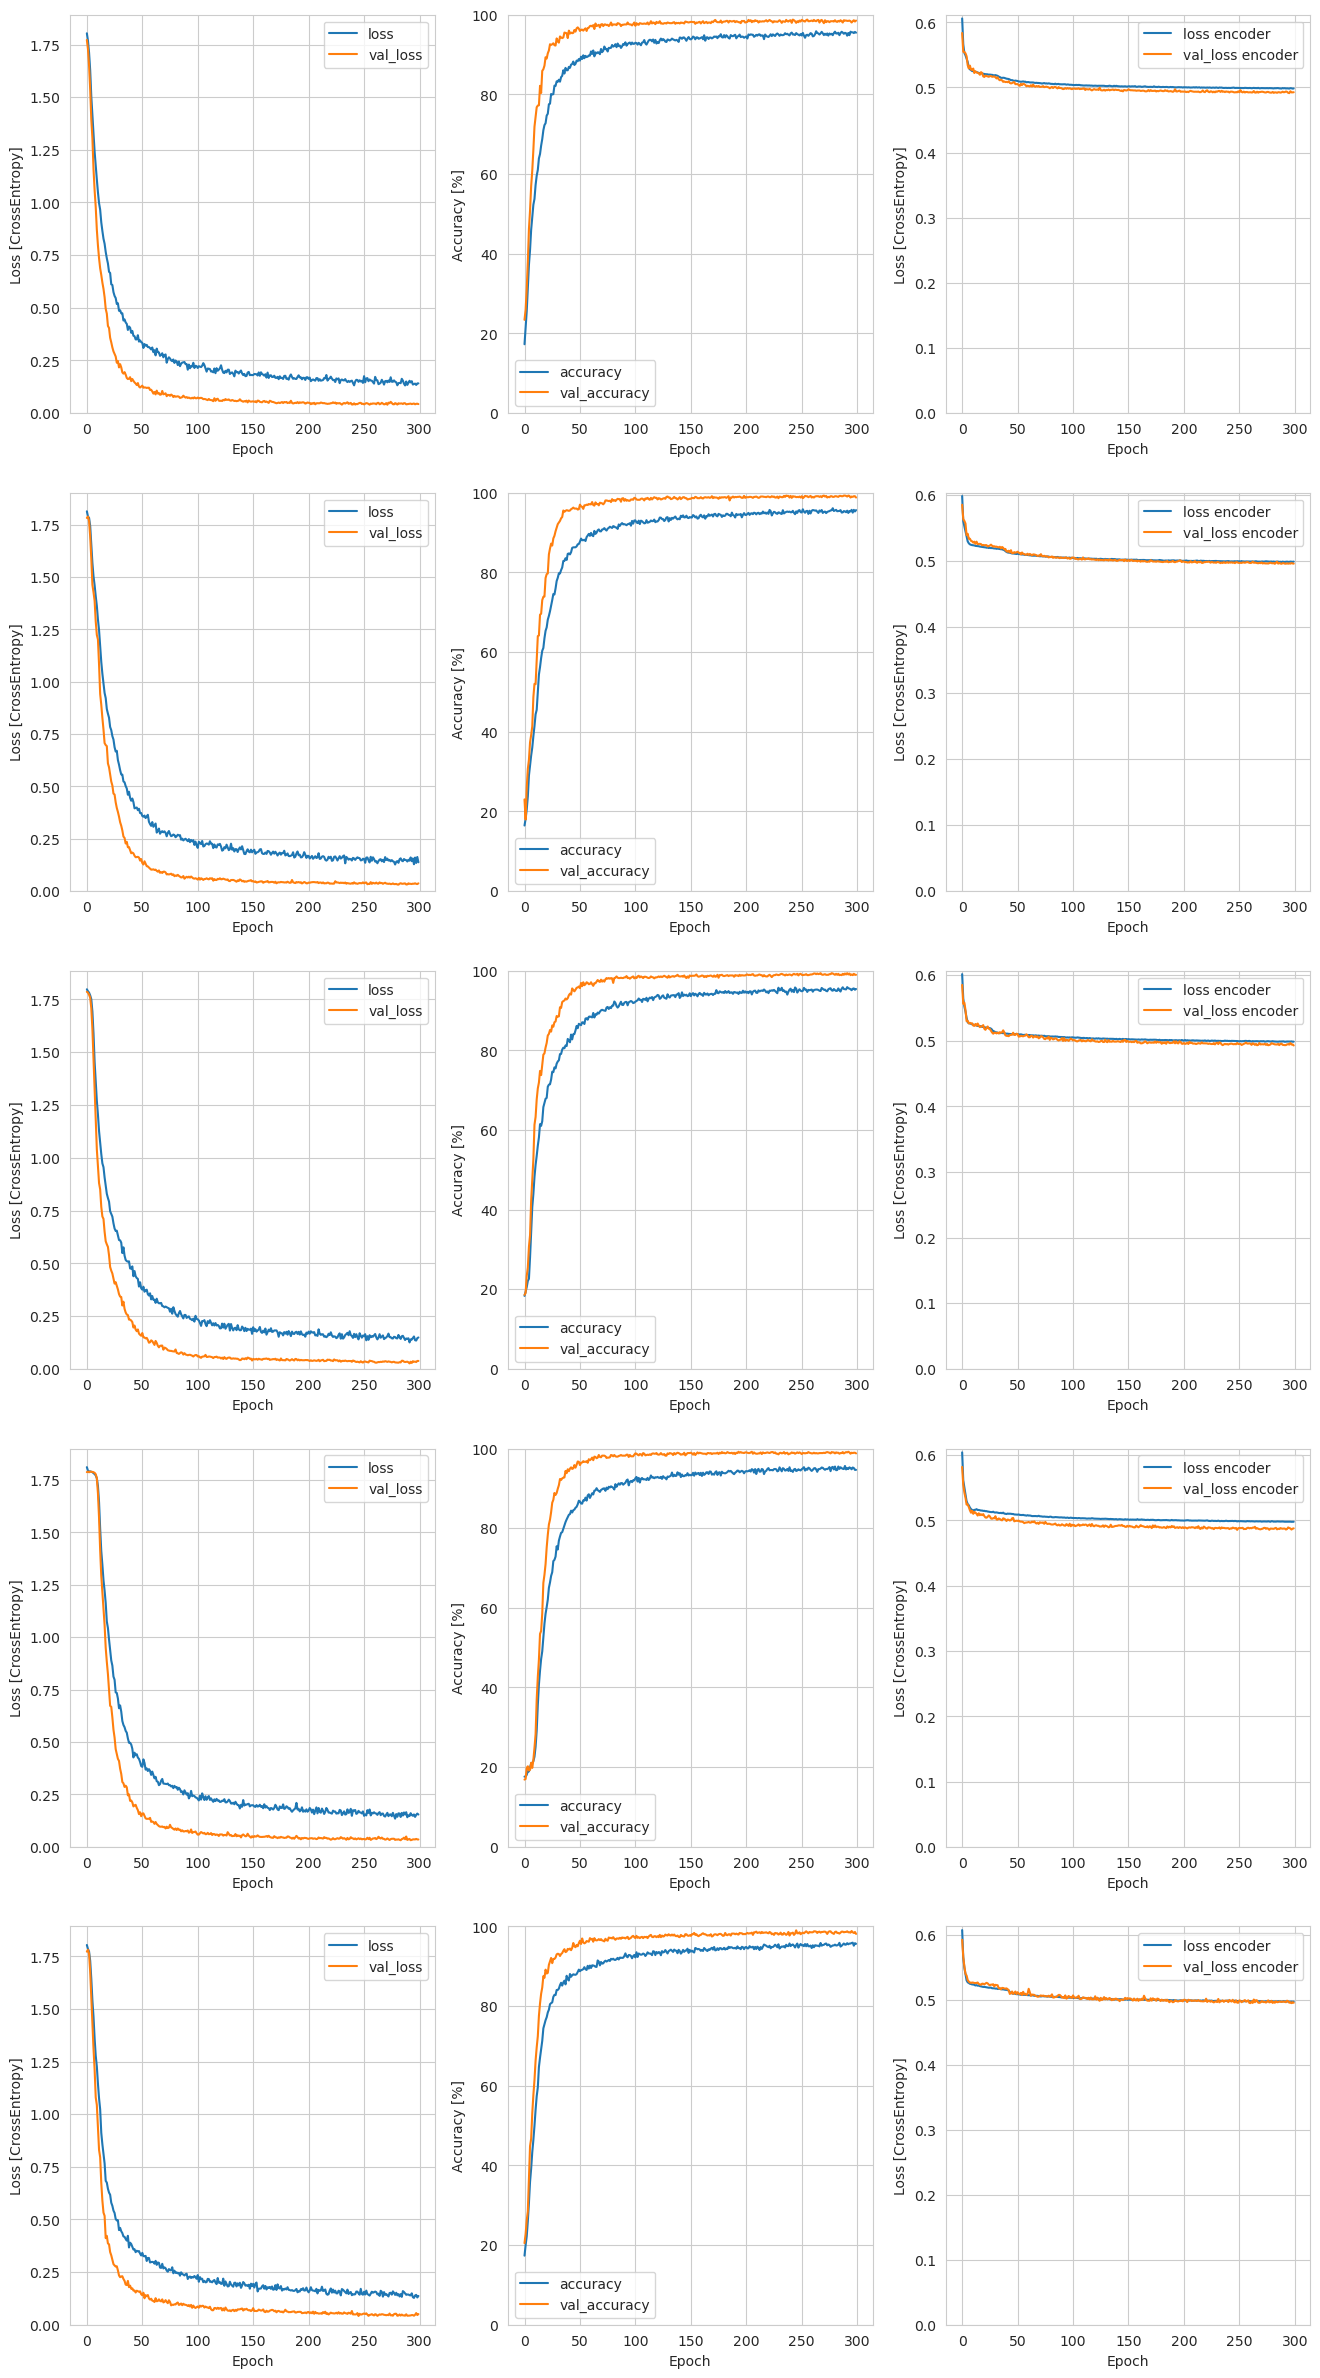

In [34]:
plt.figure(figsize=(16,6 * num_folds))
for i in range(num_folds):
  metrics = histories[i].history
  plt.subplot(num_folds,3,3 * i + 1)
  plt.plot(histories[i].epoch, metrics['classification_output_loss'], metrics['val_classification_output_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.ylim([0, max(plt.ylim())])
  plt.xlabel('Epoch')
  plt.ylabel('Loss [CrossEntropy]')

  plt.subplot(num_folds,3,3 * i + 2)
  plt.plot(histories[i].epoch, 100*np.array(metrics['classification_output_accuracy']), 100*np.array(metrics['val_classification_output_accuracy']))
  plt.legend(['accuracy', 'val_accuracy'])
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy [%]')

  metrics = histories[i].history
  plt.subplot(num_folds,3,3 * i + 3)
  plt.plot(histories[i].epoch, metrics['reconstruction_output_loss'], metrics['val_reconstruction_output_loss'])
  plt.legend(['loss encoder', 'val_loss encoder'])
  plt.ylim([0, max(plt.ylim())])
  plt.xlabel('Epoch')
  plt.ylabel('Loss [CrossEntropy]')

In [35]:
for i in range(num_folds):
    print("accuracy = ", acc_per_fold[i], ", loss = ", loss_per_fold[i], sep="")

accuracy = 0.9853300452232361, loss = 0.04236116260290146
accuracy = 0.9877750873565674, loss = 0.03621513396501541
accuracy = 0.9894050359725952, loss = 0.037511713802814484
accuracy = 0.9877750873565674, loss = 0.034822363406419754
accuracy = 0.9812397956848145, loss = 0.050590503960847855


## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [36]:
classification_models = []
encoder_models = []
for i in range(num_folds):
    classification_model = tf.keras.Model(
        inputs=my_models[i].input,
        outputs=my_models[i].get_layer('classification_output').output
    )
    # Компилируем подмодель с нужными функцией потерь и метриками
    classification_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    )
    classification_models.append(classification_model)

    encoder_model = tf.keras.Model(
        inputs=my_models[i].input,
        outputs=my_models[i].get_layer('reconstruction_output').output
    )
    encoder_model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
    )
    encoder_models.append(encoder_model)

In [37]:
for i in range(num_folds):
    classification_models[i].evaluate(test_spectrogram_ds, return_dict=True)

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0413

2025-04-16 16:07:07.442502: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[41,8,128,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[41,1,128,64]{3,2,1,0} %bitcast.503, f32[8,1,3,3]{3,2,1,0} %bitcast.510, f32[8]{0} %bitcast.512), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/conv2d_5_1/convolution" source_file="/root/anaconda3/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-16 16:07:07.534878: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially 

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 0.0422
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0392
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0514
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0535
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0524


# Предсказание спектрограмм

2025-04-16 16:07:11.391517: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-16 16:07:13.232380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


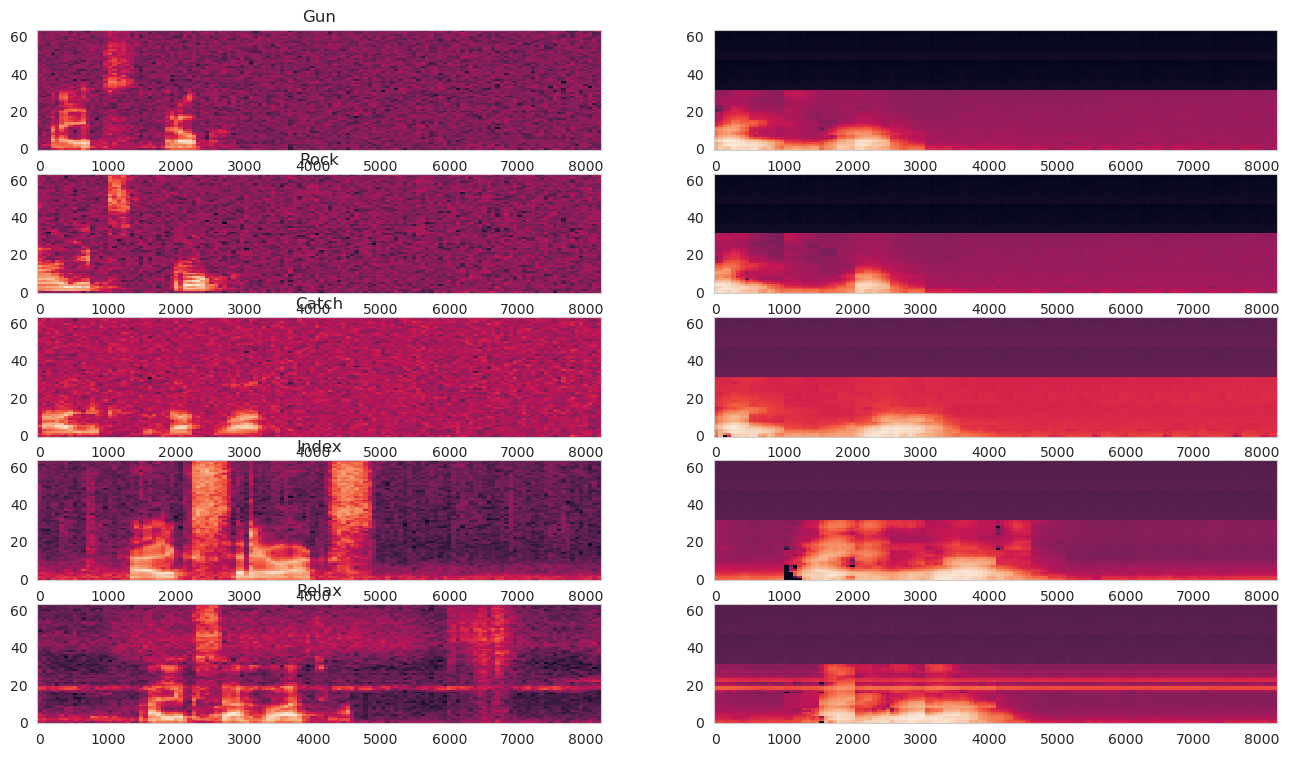

In [38]:
samples = 5
fig, axes = plt.subplots(samples, 2, figsize=(16, 9))
model = my_models[0]
for i in range(samples):
    plot_spectrogram(list(test_spectrogram_ds)[0][0][i], axes[i][0])
    axes[i][0].set_title(label_names[example_spect_labels[i].numpy()])
    plot_spectrogram(encoder_models[0].predict(test_spectrogram_ds, verbose=0)[i] + 0.001, axes[i][1])
plt.show()

In [39]:
encoder_models[0].predict(test_spectrogram_ds, verbose=0)[0].mean(),\
encoder_models[0].predict(test_spectrogram_ds, verbose=0)[1].mean(),\
encoder_models[0].predict(test_spectrogram_ds, verbose=0)[2].mean(),\
encoder_models[0].predict(test_spectrogram_ds, verbose=0)[3].mean(),\
encoder_models[0].predict(test_spectrogram_ds, verbose=0)[4].mean()

(0.28717458, 0.22622038, 0.20291036, 0.39633548, 0.34099665)

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [40]:
y_pred = []
for i in range(num_folds):
    y_pred.append(classification_models[i].predict(test_spectrogram_ds))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [41]:
y_pred[0]

array([[ -5.2209773 ,  -3.4562397 , -12.563481  ,  -5.7963514 ,
         -2.7315693 ,  19.946575  ],
       [ -0.8249677 ,  -1.8952544 , -10.489998  ,  -4.225766  ,
         -1.1545858 ,  12.845012  ],
       [ 13.944456  ,  -3.78589   ,  -6.2295322 ,  -4.244566  ,
         -1.813204  ,  -0.42521098],
       ...,
       [ -3.2574918 ,  20.293066  , -15.644128  ,  -2.2892816 ,
          0.2700404 ,  -5.9377623 ],
       [ -3.0466535 ,  -2.7850642 ,  13.468252  ,  -0.766113  ,
         -1.7986386 ,  -2.73149   ],
       [ -4.1100965 ,  -1.9991267 ,  16.894846  ,  -2.590171  ,
         -0.7658488 ,  -6.203754  ]], dtype=float32)

In [42]:
for i in range(num_folds):
    y_pred[i] = tf.argmax(y_pred[i], axis=1)

In [43]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [44]:
y_pred[0]

<tf.Tensor: shape=(681,), dtype=int64, numpy=
array([5, 5, 0, 4, 0, 5, 1, 0, 1, 0, 2, 3, 0, 5, 5, 0, 4, 5, 1, 4, 5, 3,
       0, 3, 0, 4, 4, 4, 3, 0, 2, 1, 2, 1, 3, 2, 2, 5, 3, 0, 1, 4, 5, 1,
       4, 4, 0, 0, 1, 3, 4, 3, 0, 0, 4, 1, 2, 0, 1, 0, 0, 2, 5, 2, 2, 3,
       4, 2, 4, 4, 4, 4, 4, 3, 5, 3, 5, 4, 5, 1, 1, 2, 3, 0, 4, 4, 1, 1,
       2, 3, 5, 5, 4, 1, 0, 2, 3, 0, 4, 1, 4, 0, 3, 2, 4, 0, 3, 2, 5, 1,
       1, 0, 3, 5, 2, 5, 3, 0, 2, 2, 2, 2, 4, 4, 0, 0, 1, 1, 4, 1, 2, 3,
       1, 5, 0, 5, 3, 2, 4, 5, 2, 5, 2, 1, 1, 1, 3, 1, 5, 2, 1, 4, 5, 4,
       2, 1, 3, 2, 0, 3, 4, 4, 4, 3, 5, 0, 0, 0, 4, 4, 3, 5, 5, 5, 1, 4,
       1, 3, 4, 1, 2, 4, 2, 4, 3, 4, 2, 3, 3, 0, 4, 5, 4, 1, 3, 0, 1, 0,
       4, 4, 0, 4, 0, 5, 0, 2, 3, 5, 1, 0, 5, 5, 2, 2, 3, 4, 2, 2, 3, 5,
       2, 0, 3, 5, 2, 3, 0, 4, 2, 2, 4, 2, 5, 0, 5, 3, 2, 3, 4, 4, 1, 3,
       5, 5, 0, 5, 0, 1, 1, 3, 0, 1, 1, 5, 4, 0, 3, 3, 5, 1, 1, 5, 2, 3,
       2, 0, 2, 0, 0, 1, 1, 3, 3, 0, 4, 3, 4, 4, 2, 2, 2, 4, 5, 0, 4, 2,
     

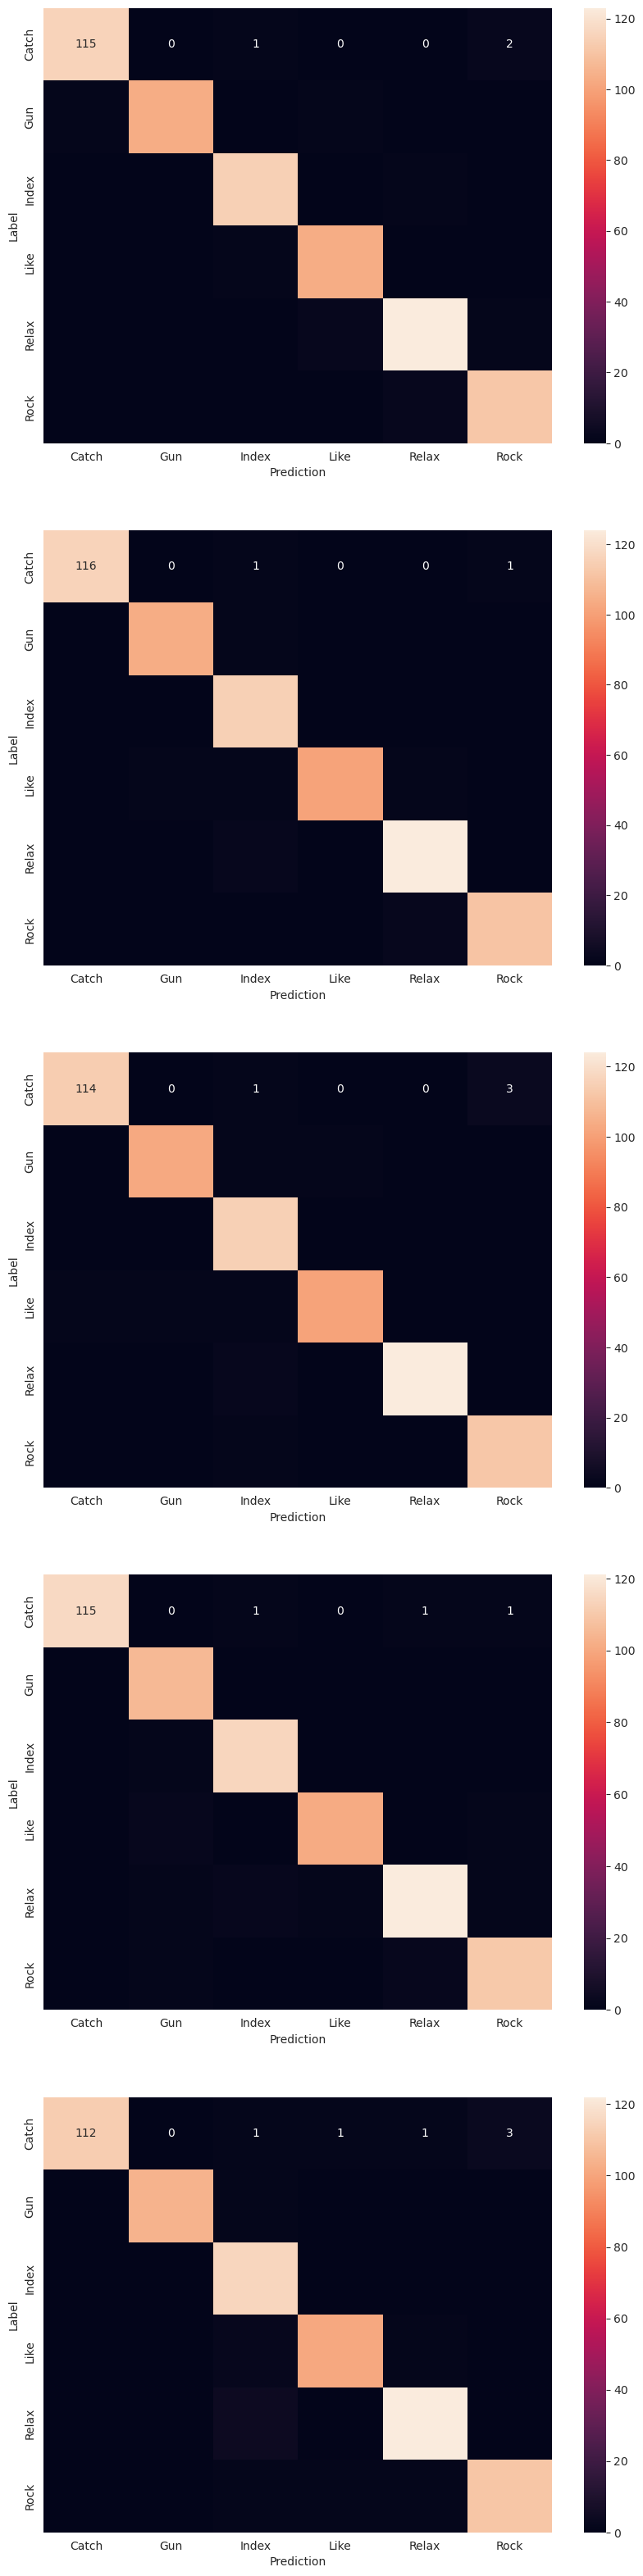

In [45]:
plt.figure(figsize=(10,8 * num_folds))
for i in range(num_folds):
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred[i])
    plt.subplot(num_folds,1,i + 1)
    sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [49]:
x = "output/ML/Catch/park_audio_2025-01-09_13-51-22.wav"
# ML/output/noisy_ML
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=41600,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
for i in range(num_folds):
    prediction = classification_models[i](x)
    print(label_names[tf.argmax(prediction[0])])
display.display(display.Audio(waveform, rate=16000))

Catch
Catch
Catch
Catch
Catch


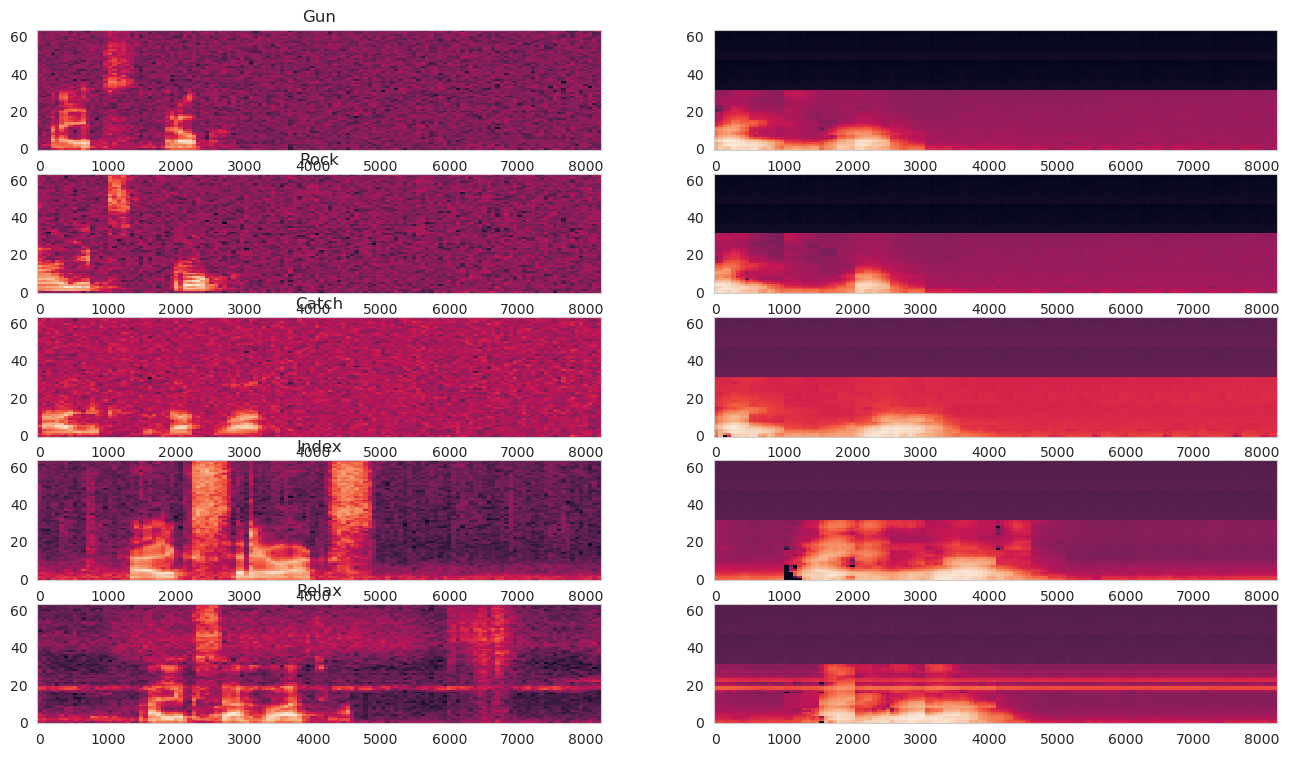

In [50]:
samples = 5
fig, axes = plt.subplots(samples, 2, figsize=(16, 9))
model = my_models[0]
for i in range(samples):
    plot_spectrogram(list(test_spectrogram_ds)[0][0][i], axes[i][0])
    axes[i][0].set_title(label_names[example_spect_labels[i].numpy()])
    plot_spectrogram(encoder_models[0].predict(test_spectrogram_ds, verbose=0)[i] + 0.001, axes[i][1])
plt.show()

In [51]:
mse_loss = tf.keras.losses.MeanSquaredError()
for x in (
    r"ML/Relax/Relax 1.wav",
    r"ML/Relax/audio_2025-01-11_19-52-02.wav",
    "Test.wav",
    "Test2.wav"
):
    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=41600,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x_old = get_spectrogram(x)
    x = x_old[tf.newaxis,...]

    for i in range(num_folds):
        print(classification_models[i])
        prediction = classification_models[i](x)
        for j in range(len(label_names)):
            print(label_names[j], ":", float(tf.nn.softmax(prediction[0])[j]), end = " ")
        print()
        print(label_names[tf.argmax(prediction[0])])
        print("\t", float(mse_loss(x, encoder_models[i](x))))
    display.display(display.Audio(waveform, rate=16000))


    samples = 5
    fig, axes = plt.subplots(samples, 2, figsize=(16, 9))
    model = my_models[0]
    for i in range(samples):
        plot_spectrogram(x_old, axes[i][0])
        axes[i][0].set_title(label_names[example_spect_labels[i].numpy()])
        plot_spectrogram(encoder_models[i].predict(x, verbose=0)[0] + 0.001, axes[i][1])
    plt.show()

2025-04-16 16:18:49.711095: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_file_read_ops.cc:117 : NOT_FOUND: ML/Relax/Relax 1.wav; No such file or directory
2025-04-16 16:18:49.711136: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: NOT_FOUND: ML/Relax/Relax 1.wav; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} ML/Relax/Relax 1.wav; No such file or directory [Op:ReadFile]

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

In [52]:
for i in range(num_folds):
    my_models[i].save(f'new_model{i+1}.h5')


In [ ]:
вапвап
for i in range(num_folds):
    my_models[i].save(f'model{i+1}.keras')  # или .h5, если необходимо


The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
    def __init__(self, model, label_names):
        self.model = model
        # Оборачиваем label_names как константу TensorFlow
        self.label_names = tf.constant(label_names)

        # Готовим конкретные функции для сохранения
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, AUDIO_LENGTH], dtype=tf.float32))

    @tf.function
    def __call__(self, x):
        # Обрабатываем строковые входные данные (пути к файлам)
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=AUDIO_LENGTH)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(self.label_names, class_ids)
        return {
            'predictions': result,
            'class_ids': class_ids,
            'class_names': class_names
        }


Test run the "export" model:

In [ ]:
for i in range(num_folds):
    export = ExportModel(my_models[i], label_names)
    print(export(tf.constant('ML/Gun/audio_2025-01-09_15-41-49.wav')))

    # Сохраняем каждую модель в уникальный каталог, чтобы избежать перезаписи
    save_path = f"saved_model_fold_{i}"
    tf.saved_model.save(export, save_path)

    # Загружаем модель обратно
    imported = tf.saved_model.load(save_path)

    # Убедитесь, что 'waveform' определён корректно перед использованием
    # Например:
    # waveform = ... (загрузите или определите ваш waveform здесь)
    # result = imported(waveform[tf.newaxis, :])


Save and reload the model, the reloaded model gives identical output:

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.